<a href="https://www.kaggle.com/code/wonduk/pokemon-data-visualization-is-or-not-legendary?scriptVersionId=92810652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Legendary Pokemon
## 1.data exploring with visualization

first, import some useful modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# to visualize missing values
import missingno as msno
# to draw plot in notebook
%matplotlib inline

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False

# for spliting train data andd test data
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_absolute_error

read the data

In [2]:
pokemon_data = pd.read_csv("../input/pokemon/pokemon_alopez247.csv")

In [3]:
pokemon = pd.DataFrame(pokemon_data)
pokemon.head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


In [4]:
pokemon.shape

(721, 23)

In [5]:
# any null values?
pokemon.isnull().sum()

Number                0
Name                  0
Type_1                0
Type_2              371
Total                 0
HP                    0
Attack                0
Defense               0
Sp_Atk                0
Sp_Def                0
Speed                 0
Generation            0
isLegendary           0
Color                 0
hasGender             0
Pr_Male              77
Egg_Group_1           0
Egg_Group_2         530
hasMegaEvolution      0
Height_m              0
Weight_kg             0
Catch_Rate            0
Body_Style            0
dtype: int64

<AxesSubplot:>

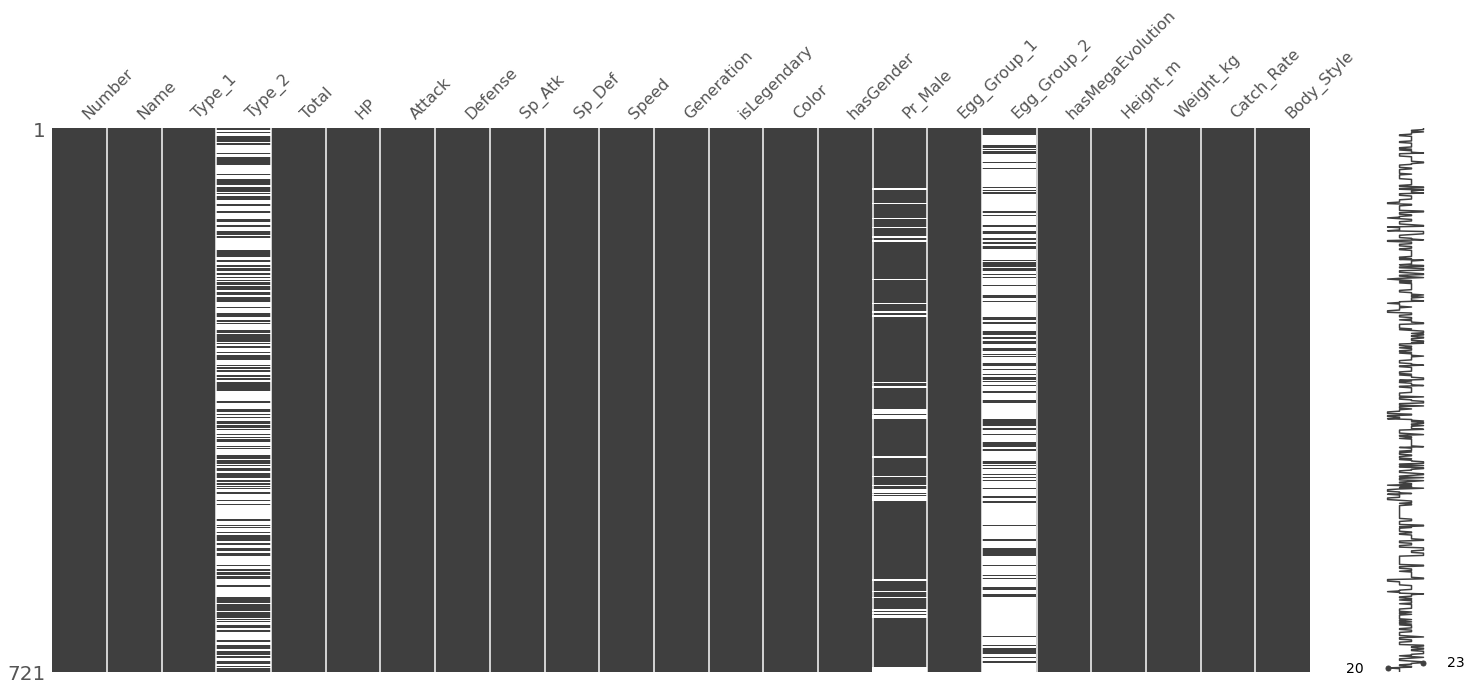

In [6]:
# here i used missingno matrix to see the distribution of null values columns
msno.matrix(pokemon)

* from above, Type_2 and Egg_Group_2 have relative null values
* and see below:

<AxesSubplot:>

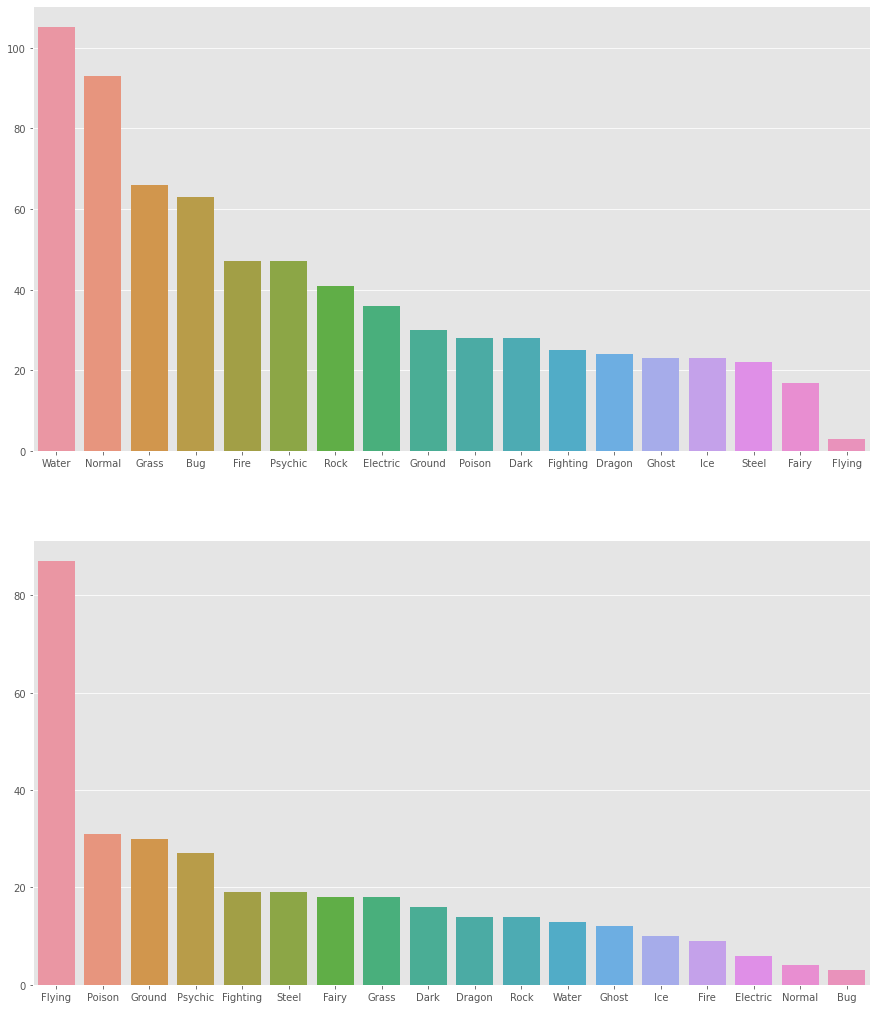

In [7]:
type1 = pokemon['Type_1'].value_counts()

type2 = pokemon['Type_2'].value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=2)

fig.set_size_inches(15,18)
# using seaborn barplot to visualize Type_1 and Type_2 
sns.barplot(x=type1.index,y=type1.values, ax= ax1)
sns.barplot(x=type2.index,y=type2.values, ax= ax2)

```
Type_2 almost consists of null vaues, so i decide to drop it later.
and from above, i can find that Type_1 has some correlate values(ex. water with ice),
and they'll be combined in feature engineering section.
```

<AxesSubplot:>

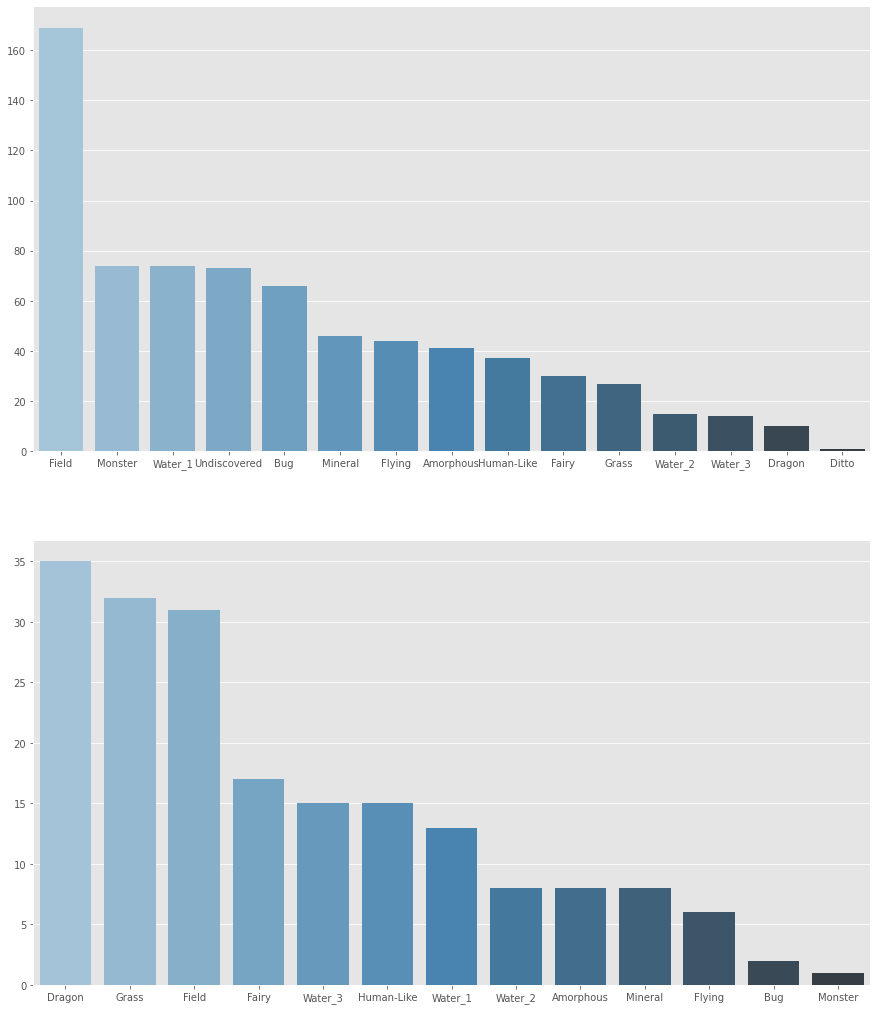

In [8]:
egg1 = pokemon['Egg_Group_1'].value_counts()

egg2 = pokemon['Egg_Group_2'].value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=2)

fig.set_size_inches(15,18)
# using seaborn barplot to visualize Type_1 and Type_2 
sns.barplot(x=egg1.index,y=egg1.values, palette="Blues_d", ax= ax1)
sns.barplot(x=egg2.index,y=egg2.values, palette="Blues_d",ax= ax2)

```
Egg_Group_2 also consists of lot null vaues, so it'll be droped.
and we can see that there're three Water columns above,
they'll be combined in feature engineering section.
```

as Pr_Male column has few null values, so i decided to fill in it

In [9]:
pokemon['Pr_Male'].value_counts()

0.500    458
0.875    101
0.000     23
0.250     22
1.000     19
0.750     19
0.125      2
Name: Pr_Male, dtype: int64

fill it with 0.500

In [10]:
pokemon['Pr_Male'].fillna(0.500, inplace=True)

let's drop two columns (Egg_Group_1, Type_2)

In [11]:
pokemon = pokemon.drop(['Type_2', 'Egg_Group_2'],axis=1)

now, see correlation between all columns below

<AxesSubplot:>

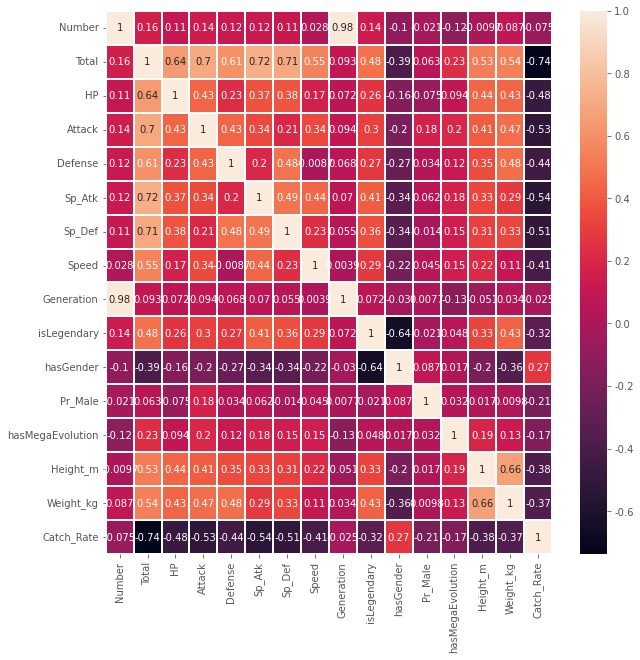

In [12]:
# # used heatmap here
# mask = np.array(pokemon.corr())
# mask[np.tril_indices_from(mask)] = False

plt.figure(figsize=(10,10))
# sns.heatmap(pokemon.corr(), annot=True,linewidths=.3)
sns.heatmap(pokemon.corr(), annot=True,linewidths=.3)

the lowest correlation is -0.64, so it seems not need to drop any columns.

In [13]:
pokemon.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,...,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,...,False,Green,True,0.875,Monster,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,525,80,82,83,100,100,80,...,False,Green,True,0.875,Monster,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,309,39,52,43,60,50,65,...,False,Red,True,0.875,Monster,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,...,False,Red,True,0.875,Monster,False,1.09,19.0,45,bipedal_tailed


and explore other columns:

In [14]:
pokemon['Body_Style'].value_counts()

bipedal_tailed      158
quadruped           135
bipedal_tailless    109
two_wings            63
head_arms            39
head_only            34
with_fins            31
insectoid            30
head_base            30
serpentine_body      29
four_wings           18
head_legs            17
multiple_bodies      15
several_limbs        13
Name: Body_Style, dtype: int64

In [15]:
pokemon['Color'].value_counts()

Blue      134
Brown     110
Green      79
Red        75
Grey       69
Purple     65
Yellow     64
White      52
Pink       41
Black      32
Name: Color, dtype: int64

In [16]:
pokemon['hasMegaEvolution'].value_counts()

False    675
True      46
Name: hasMegaEvolution, dtype: int64

In [17]:
pokemon['Body_Style'].value_counts()

bipedal_tailed      158
quadruped           135
bipedal_tailless    109
two_wings            63
head_arms            39
head_only            34
with_fins            31
insectoid            30
head_base            30
serpentine_body      29
four_wings           18
head_legs            17
multiple_bodies      15
several_limbs        13
Name: Body_Style, dtype: int64

In [18]:
pokemon['Body_Style'].value_counts()

bipedal_tailed      158
quadruped           135
bipedal_tailless    109
two_wings            63
head_arms            39
head_only            34
with_fins            31
insectoid            30
head_base            30
serpentine_body      29
four_wings           18
head_legs            17
multiple_bodies      15
several_limbs        13
Name: Body_Style, dtype: int64

## 2. feature engineering

here's feature engineering below:

In [19]:
# Type_1 and Egg_Group_1 
pokemon = pokemon.replace(['Water', 'Ice'],'Water_Ice')
pokemon = pokemon.replace(['Grass', 'Bug'],'Grass_Bug')
pokemon = pokemon.replace(['Ground', 'Rock'],'Ground_Rock')
pokemon = pokemon.replace(['Psychic','Dark','Ghost',"Fairy"],'Psychic_Dark_Ghost_Fairy')
pokemon = pokemon.replace(['Electric','Steel'],'ELectric_Steel')

pokemon = pokemon.replace(['Water_1','Water_2','Water_3'],'Water')

In [20]:
pokemon.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass_Bug,318,45,49,49,65,65,45,...,False,Green,True,0.875,Monster,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass_Bug,405,60,62,63,80,80,60,...,False,Green,True,0.875,Monster,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass_Bug,525,80,82,83,100,100,80,...,False,Green,True,0.875,Monster,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,309,39,52,43,60,50,65,...,False,Red,True,0.875,Monster,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,...,False,Red,True,0.875,Monster,False,1.09,19.0,45,bipedal_tailed


dummy variable below:

In [21]:
ref1 = dict(pokemon['Body_Style'].value_counts())

pokemon['Body_Style'] = pokemon['Body_Style'].map(ref1)

In [22]:
types_poke = pd.get_dummies(pokemon["Type_1"])
color_poke = pd.get_dummies(pokemon['Color'])

X = pd.concat([pokemon, types_poke],axis = 1)
X = pd.concat([X, color_poke], axis=1)

X.head()

,Number,Name,Type_1,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,...,Black,Blue,Brown,Green,Grey,Pink,Purple,Red,White,Yellow
0,1,Bulbasaur,Grass_Bug,318,45,49,49,65,65,45,...,0,0,0,1,0,0,0,0,0,0
1,2,Ivysaur,Grass_Bug,405,60,62,63,80,80,60,...,0,0,0,1,0,0,0,0,0,0
2,3,Venusaur,Grass_Bug,525,80,82,83,100,100,80,...,0,0,0,1,0,0,0,0,0,0
3,4,Charmander,Fire,309,39,52,43,60,50,65,...,0,0,0,0,0,0,0,1,0,0
4,5,Charmeleon,Fire,405,58,64,58,80,65,80,...,0,0,0,0,0,0,0,1,0,0


and create X, y value used for predict legendary pokemon

In [23]:
y = pokemon.isLegendary
X = X.drop(['Number','Type_1',"Name",'Color','Egg_Group_1','isLegendary'],axis=1)

## 3.RandomForestClassifier

split data using train_test_split

In [24]:
train_X,val_X, train_y, val_y = train_test_split(X, y, test_size=0.3)

modeling:

In [25]:
for n_estimators in [5,50,100,200,400,500,1000,5000]:
    model = RandomForestClassifier(n_estimators=n_estimators,random_state=10)
    model.fit(train_X, train_y)
    random_model_accuracy = round(model.score(val_X,val_y)*100,2)
    print(round(random_model_accuracy,2),'%')

98.16 %
99.08 %
99.08 %
99.08 %
99.08 %
99.08 %
99.08 %
99.08 %
